# Project 2: Linear Classification

# Part 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# Generating Training and Testing Data
# Creating a class for the dataset
class Data_set:
    def __init__(self, mean, cov):
        self.mean = mean
        self.cov  = cov
    
    def split_data(self):
        np.random.shuffle(self.data)
        self.train = self.data[:len(self.data)//2]
        self.test  = self.data[len(self.data)//2:]
        
        return self
    
    def multivariate_normal(self, num):
        # asself.data.shape = numx2
        self.data = np.random.multivariate_normal(self.mean,self.cov,size=num)
    
        return self


In [2]:
#### Given parameters
mean1 = np.array([1,1])
mean2 = np.array([-1,-1])
cov1 = np.array([[3,2],[2,3]])
cov2 = np.array([[2,-1],[-1,2]])

#### Generating dataset and spliting dataset
c1 = Data_set(mean1,cov1)
c1 = c1.multivariate_normal(200)
c1 = c1.split_data()
# c1.train, c1.test
c2 = Data_set(mean2,cov2)
c2 = c2.multivariate_normal(200)
c2 = c2.split_data()


Text(0.5, 1.0, 'Fig 2. Testing Data')

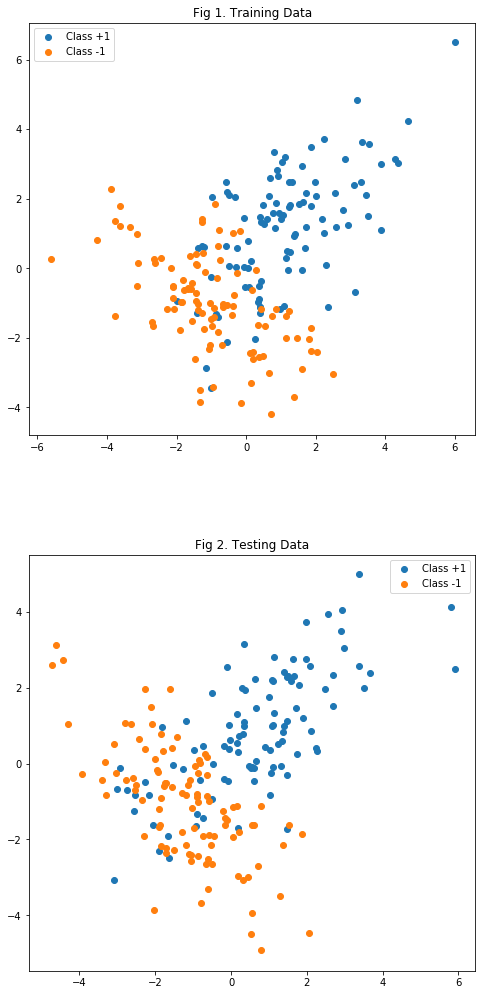

In [3]:
fig = plt.figure(1,figsize=(8,18))

ax_train = fig.add_subplot(211, aspect='equal')
ax_train.scatter(c1.train[:,0], c1.train[:,1], label="Class +1")
ax_train.scatter(c2.train[:,0], c2.train[:,1], label="Class -1")
ax_train.legend()
ax_train.set_title("Fig 1. Training Data")

ax_test  = fig.add_subplot(212, aspect='equal')
ax_test.scatter(c1.test[:,0], c1.test[:,1], label="Class +1")
ax_test.scatter(c2.test[:,0], c2.test[:,1], label="Class -1")
ax_test.legend()
ax_test.set_title("Fig 2. Testing Data")

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis()
clf.fit()